# ISOKANN example with Feedforward Neural Network
ISOKANN is an algorithm that uses machine learning techniques to identify invariant subspaces of the Koopman operator.
The following implementation is based on the original ISOKANN version described in Ref. [1] and summarized in Ref. [2].

This version of ISOKANN introduces improvements over the version in the top folder.
Important features:

- Torch-based
- The main functions are collected in classes and functions in the modules directory
- Random search is used to optimise hyperparameters
- A validation test is introduced
- The power method stops if convergence is below a certain threshold
  
__References__

[1] R. J. Rabben, S. Ray, M. Weber; ISOKANN: Invariant subspaces of Koopman operators learned by a neural network. 
[J. Chem. Phys. 153, 114109 (2020)](https://pubs.aip.org/aip/jcp/article-abstract/153/11/114109/199583/ISOKANN-Invariant-subspaces-of-Koopman-operators)

[2] L. Donati; [Notes about ISOKANN algorithm](https://www.zib.de/userpage/donati/SeminarSOSE2024/06/lecture_notes/L06.pdf)

Torch is on: cpu
Thermal energy: 2.4943389


10*(x**2 - 1)**2

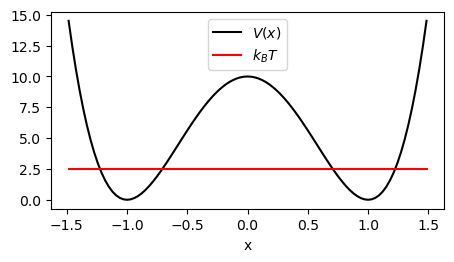

In [1]:
import numpy as np
import sympy as sp
import torch as pt
from tqdm import tqdm
import scipy 
import random

import sys
# Add parent directory to sys.path
sys.path.append("..")
from modules.other_functions import discretize_axis, Potential1D_car, SystemParameters, scale_and_shift, exit_rates_from_chi
from modules.NN_modules import NeuralNetwork, trainNN, random_search, power_method

import matplotlib.pyplot as plt

# Check if CUDA is available, otherwise use CPU
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print(f"Torch is on: {device}")

# For reproducibility
np.random.seed(0)
pt.manual_seed(0)

# For figures
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# System parameters
SPs  = SystemParameters()


print("Thermal energy:", SPs.kB * SPs.T)

# Potential energy function
x      =  sp.symbols('x')

P1D = Potential1D_car( 10*(x**2 - 1)**2 )

## Plot potential
ax, xedges, xbins, dx = discretize_axis(-1.5, 1.5, 100)

fig = plt.figure(figsize=(10*in2cm, 5*in2cm))

plt.plot(ax, P1D.V(ax), 'k-', label = r'$V(x)$')
plt.plot(ax, SPs.kB * SPs.T * np.ones(xbins),'r', label = r'$k_B T$')
plt.legend()
plt.xlabel('x')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.5)
#fig.savefig('potential.png', format='png', dpi=300, bbox_inches='tight')

Load the data set of initial points $x_0$.
Load the data set of final points $x_t$.

In [2]:
# Load initial points
x0 = np.loadtxt('x0.txt')
print("x0.shape =", x0.shape)

Npoints = len(x0)
print("Npoints = ", Npoints)

# Load final points
xt = np.loadtxt('xt.txt')
print("xt.shape =", xt.shape)

Npoints      = xt.shape[0]  # == len(x0)
Nfinpoints   = xt.shape[1]
print("Nfinpoints = ", Nfinpoints)


# Length of each trajectory (this information is used later for rate estimation)
Nsteps = 200
# Integrator time step used for simulations
dt     = 0.001

x0.shape = (200,)
Npoints =  200
xt.shape = (200, 300)
Nfinpoints =  300


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.33s/it]


The best hyperparameters are: {'nodes': array([ 1, 64, 64,  1]), 'learning_rate': 0.01}


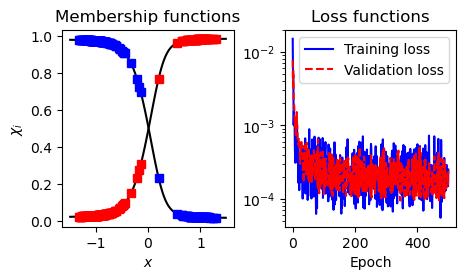

In [3]:
# This cell implements the modified power method 

# Convert x0 and add one dimension, such that pt_x0.shape = (Npoints, 1)
pt_x0     =  pt.tensor(x0, dtype=pt.float32, device=device).unsqueeze(1)

# Convert xt and add one dimension, such that pt_xt.shape = (Npoints, Nfinpoints, 1)
pt_xt     =  pt.tensor(xt, dtype=pt.float32, device=device).unsqueeze(2)

# Find the optimal hyperparameters using random search
NN_layers =          [(SPs.Ndims, 32, 1), 
                      (SPs.Ndims, 64, 1), 
                      (SPs.Ndims, 32, 32, 1),
                      (SPs.Ndims, 64, 64, 1), 
                      (SPs.Ndims, 32, 64, 1)]

learning_rates = [0.01, 
                  0.001, 
                  0.0001]

best_hyperparams, best_val_loss = random_search(pt_x0, pt_xt, NN_layers, learning_rates, search_iterations=10)

print("The best hyperparameters are:", best_hyperparams)

nodes = best_hyperparams['nodes']
lr    = best_hyperparams['learning_rate']

# Define the interpolating function
f_k = NeuralNetwork( Nodes = np.asarray(nodes), enforce_positive = 1 )

# Apply the power method using the best hyperparameters
train_LOSS, val_LOSS, best_loss = power_method(pt_x0, pt_xt, f_k, scale_and_shift, Niters = 500, tolerance  = 5e-3, lr = lr)

pt_ax  =  pt.tensor(ax, dtype=pt.float32).unsqueeze(1)
y      =  f_k(pt_ax).cpu().detach().numpy()
chi    =  f_k(pt_x0).cpu().detach().numpy()

## Plot chi function and loss functions
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10*in2cm, 5*in2cm))

ax1.plot(ax, y, 'k')
ax1.plot(ax, 1-y, 'k')

ax1.plot(x0, chi,   'sb')
ax1.plot(x0, 1-chi,   'sr')

ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$\chi_i$')
ax1.set_title('Membership functions')

#ax.set_ylim(-0.1,1.1);

ax2.plot(train_LOSS, 'b', label='Training loss')
ax2.plot(val_LOSS,   'r--', label='Validation loss')

ax2.set_xlabel('Epoch')
ax2.set_title('Loss functions')
#ax.set_ylim(0,0.01)
ax2.set_yscale('log')
ax2.legend()

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.5)
#fig.savefig('chi_1D.png', format='png', dpi=300, bbox_inches='tight')

In [4]:
chi_0   = f_k(pt_x0).cpu().detach().numpy()
y       = f_k(pt_xt).cpu().detach().numpy()
chi_tau = np.mean( y, axis=1 )

chi_0         = np.array([chi_0,      1 - chi_0]).T
chi_tau       = np.array([chi_tau,    1 - chi_tau]).T


rate1, rate2  = exit_rates_from_chi(Nsteps * dt, chi_0, chi_tau)

Exit rate 1: 0.14406256420067018
Exit rate 2: 0.15088843966174628
